In [13]:
import os
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns

# 結果ファイルのパス
output_dir = os.path.join(os.getcwd(), "results/hyper_params_MC")
if not os.path.exists(output_dir):
    raise FileNotFoundError(f"The specified directory does not exist: {output_dir}")

def load_results(output_dir):
    results = []
    for file_name in os.listdir(output_dir):
        file_path = os.path.join(output_dir, file_name)
        if file_name.endswith(".pkl") and os.path.getsize(file_path) > 0:
            with open(file_path, "rb") as f:
                try:
                    result = pickle.load(f)
                    if isinstance(result, dict):
                        results.append(result)
                except (EOFError, pickle.UnpicklingError):
                    print(f"Warning: Could not load {file_name}, it may be corrupted.")
    return results

# データの読み込み
results = load_results(output_dir)

# データフレームに変換して、視覚化に備える
data = pd.DataFrame([r for r in results if all(key in r for key in ["Spectral Radius", "Units", "RC Connectivity", "Memory Capacity", "R2 Scores"])])

# R2 Scoresを展開して、新しいデータフレームを作成
expanded_data = []
for _, row in data.iterrows():
    for r2 in row["R2 Scores"]:
        expanded_data.append({
            "Spectral Radius": row["Spectral Radius"],
            "Units": row["Units"],
            "RC Connectivity": row["RC Connectivity"],
            "R2 Score": r2
        })
expanded_df = pd.DataFrame(expanded_data)

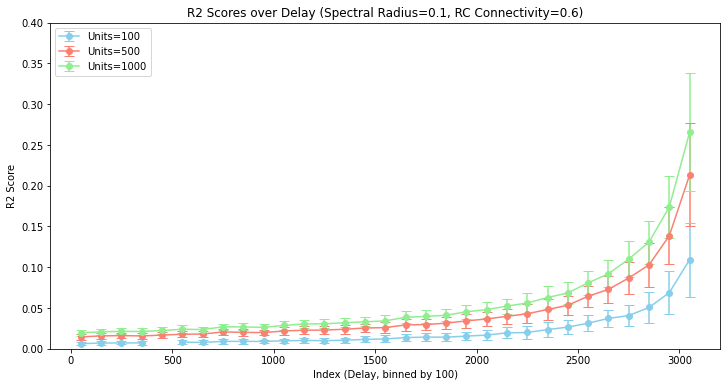

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 複数のUnitsの値を指定
unit_values = [100, 500, 1000]
selected_params = {"Spectral Radius": 0.1, "RC Connectivity": 0.6}

# プロット設定
plt.figure(figsize=(12, 6))
colors = ['skyblue', 'salmon', 'lightgreen']

for idx, units in enumerate(unit_values):
    # dataから指定したUnitsとその他のハイパーパラメータの組み合わせを抽出
    filtered_row = data[
        (data["Units"] == units) &
        (data["Spectral Radius"] == selected_params["Spectral Radius"]) &
        (data["RC Connectivity"] == selected_params["RC Connectivity"])
    ]

    # R2 Scoresが見つかった場合のみプロット
    if not filtered_row.empty:
        r2_scores = filtered_row.iloc[0]["R2 Scores"]  # R2 Scoresのリストを取得

        # 100ごとの区切りで平均と標準偏差を計算
        bin_size = 100
        means = []
        std_devs = []
        indices = []

        for i in range(0, len(r2_scores), bin_size):
            bin_scores = r2_scores[i:i + bin_size]
            if len(bin_scores) > 0:
                means.append(np.mean(bin_scores))
                std_devs.append(np.std(bin_scores))
                indices.append(i + bin_size / 2)  # 区間の中心をインデックスとする

        # エラーバー付きの線グラフをプロット
        plt.errorbar(indices, means, yerr=std_devs, fmt='-o', capsize=5, color=colors[idx], label=f"Units={units}")

# プロット設定
plt.title(f"R2 Scores over Delay (Spectral Radius={selected_params['Spectral Radius']}, RC Connectivity={selected_params['RC Connectivity']})")
plt.xlabel("Index (Delay, binned by 100)")
plt.ylabel("R2 Score")
plt.ylim(0, 0.4)  # 必要に応じてY軸の範囲を設定
plt.legend()
plt.show()

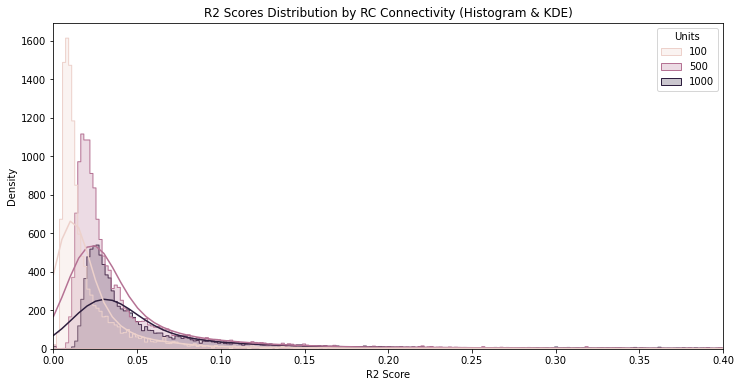

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(expanded_df, x="R2 Score", hue="Units", kde=True, element="step")
plt.title("R2 Scores Distribution by RC Connectivity (Histogram & KDE)")
plt.xlabel("R2 Score")
plt.ylabel("Density")

# 横軸の範囲を0〜0.4に設定
plt.xlim(0, 0.4)

plt.show()

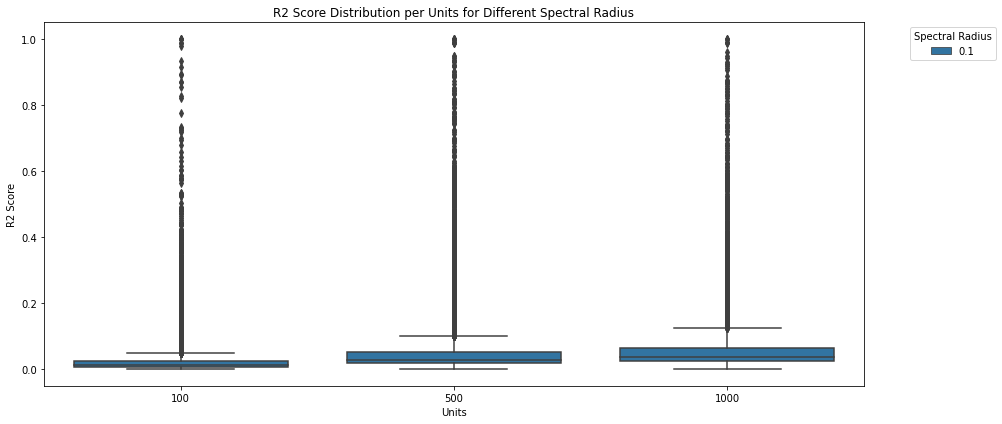

In [16]:
# 2. ボックスプロットでR2 Scoresの分布を表示
plt.figure(figsize=(14, 6))
sns.boxplot(x="Units", y="R2 Score", hue="Spectral Radius", data=expanded_df)
plt.title("R2 Score Distribution per Units for Different Spectral Radius")
plt.xlabel("Units")
plt.ylabel("R2 Score")
plt.legend(title="Spectral Radius", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

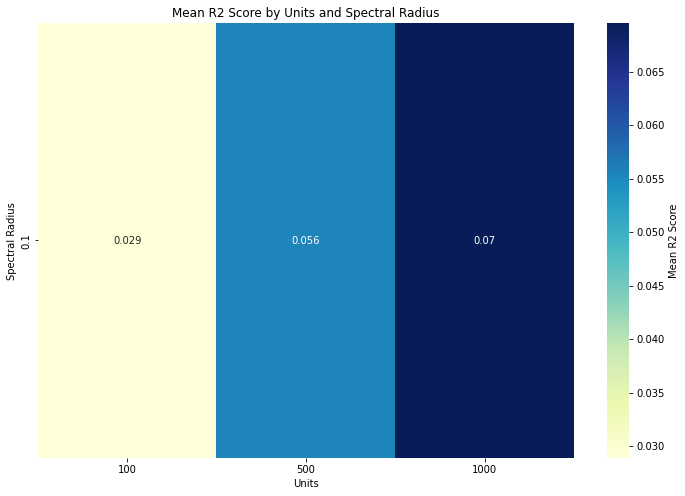

In [17]:
# 3. ヒートマップでR2 Scoresの平均を表示
pivot_table = expanded_df.pivot_table(values="R2 Score", index="Spectral Radius", columns="Units", aggfunc="mean")
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={"label": "Mean R2 Score"})
plt.title("Mean R2 Score by Units and Spectral Radius")
plt.xlabel("Units")
plt.ylabel("Spectral Radius")
plt.show()